## Предобработка данных

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler

In [247]:
df = pd.read_csv("Tesla_Nasdaq_Prediction.csv")
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,4/8/2022,1025.49,18337900,1043.21,1048.44,1022.44
1,4/7/2022,1057.26,26482350,1052.39,1076.59,1021.54
2,4/6/2022,1045.76,29782850,1073.47,1079.00,1027.70
3,4/5/2022,1091.26,26691670,1136.30,1152.87,1087.30
4,4/4/2022,1145.45,27392570,1089.38,1149.91,1072.53


Date – Дата торгов (месяц/день/год).

Close/Last – Цена закрытия (последняя цена, по которой акция торговалась в этот день).

Volume – Объем торгов (количество акций, проданных за день).

Open – Цена открытия (первая цена, по которой акция торговалась в этот день).

High – Максимальная цена за день.

Low – Минимальная цена за день.

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2517 non-null   object 
 1   Close/Last  2517 non-null   float64
 2   Volume      2517 non-null   int64  
 3   Open        2517 non-null   float64
 4   High        2517 non-null   float64
 5   Low         2517 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 118.1+ KB


In [137]:
df.isna().any().any()

False

In [138]:
df['Date'] = pd.to_datetime(df['Date'], unit='ns')
df['Date'].head()

0   2022-04-08
1   2022-04-07
2   2022-04-06
3   2022-04-05
4   2022-04-04
Name: Date, dtype: datetime64[ns]

In [139]:
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

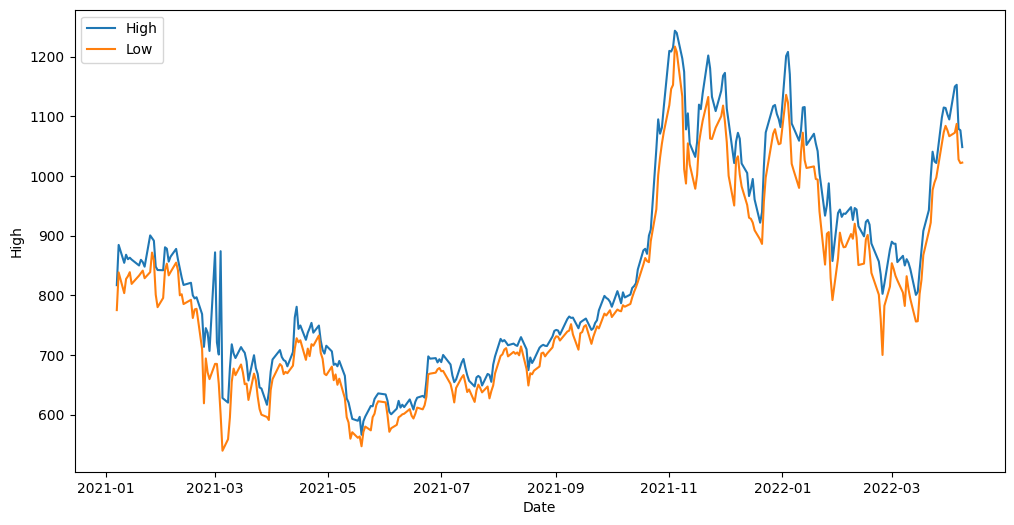

In [140]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.loc[2200:, 'Date'], y=df['High'], label='High')
sns.lineplot(x=df.loc[2200:, 'Date'], y=df['Low'], label='Low')
plt.legend(loc="upper left")

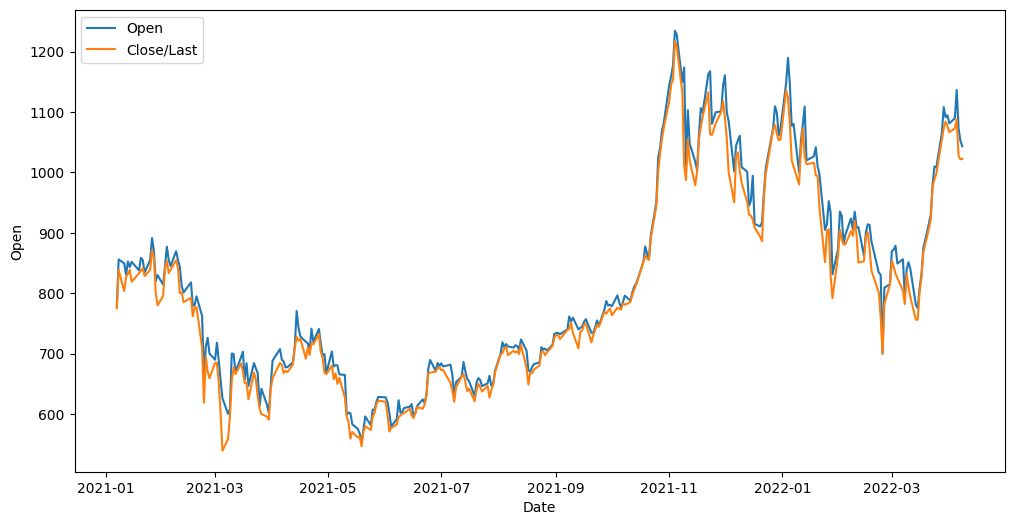

In [141]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.loc[2200:, 'Date'], y=df['Open'], label='Open')
sns.lineplot(x=df.loc[2200:, 'Date'], y=df['Low'], label='Close/Last')
plt.legend(loc="upper left")

In [142]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(df.drop(['Date', 'Close/Last'], axis=1))
y_scaler.fit(df[['Close/Last']])

StandardScaler()

In [143]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(x_scaler.transform(data.drop(target, axis=1)[i:i+seq_length]))
        # print(data.loc[i+seq_length, target].to_numpy().reshape(1, -1))
        y.append(y_scaler.transform(data.loc[i+seq_length, target].to_numpy().reshape(1, -1)))
    return np.array(X), np.array(y)

seq_length = 13
X, Y = create_sequences(df.drop('Date', axis=1), ['Close/Last'], seq_length)

c:\Users\Jrytoeku Qtuhtc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Jrytoeku Qtuhtc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Jrytoeku Qtuhtc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Jrytoeku Qtuhtc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Jrytoeku Qtuhtc\AppData\Local\Programs\Python\Python310\lib

In [144]:
x_train, x_test, y_train, y_test = X[:-400], X[-400:], Y[:-400], Y[-400:]

In [145]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train).squeeze(-1)
y_test = torch.FloatTensor(y_test).squeeze(-1)

## Глубокая RNN

In [173]:
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [227]:
class DeepRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size1=32, hidden_size2=64, num_layers1=2, num_layers2=1, output_size=1, dropout=0.2):
        super(DeepRNN, self).__init__()
    
        self.rnn1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size1,
            num_layers=num_layers1,
            batch_first=True,
            dropout=dropout if num_layers1 > 1 else 0,
        )
        
        self.fc1 = nn.Linear(hidden_size1, hidden_size1)
        self.activation = nn.ReLU()

        self.rnn2 = nn.GRU(
            input_size=hidden_size1,
            hidden_size=hidden_size2,
            num_layers=num_layers2,
            batch_first=True,
            dropout=dropout if num_layers2 > 1 else 0,
        )
        
        self.fc2 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out1, _ = self.rnn1(x)
        out1 = self.fc1(out1)
        out1 = self.activation(out1)

        out2, _ = self.rnn2(out1)
        out = self.fc2(out2[:, -1, :])
        return out

In [241]:
device = torch.device('cuda')
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

model = DeepRNN(input_size=4, hidden_size1=160, hidden_size2=96, 
                num_layers1=2, num_layers2=2, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

train_losses = []
test_losses = []
n_epoches = 200
for epoch in range(n_epoches):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    test_losses.append(criterion(model(x_test), y_test).item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train loss: {train_losses[-1]:.6f}, Test loss: {test_losses[-1]:.6f}')

Epoch 10, Train loss: 0.045825, Test loss: 5.565969
Epoch 20, Train loss: 0.010900, Test loss: 1.642447
Epoch 30, Train loss: 0.004984, Test loss: 2.398913
Epoch 40, Train loss: 0.002716, Test loss: 1.556030
Epoch 50, Train loss: 0.001628, Test loss: 1.187595
Epoch 60, Train loss: 0.001192, Test loss: 0.942331
Epoch 70, Train loss: 0.000970, Test loss: 0.839822
Epoch 80, Train loss: 0.000799, Test loss: 0.750701
Epoch 90, Train loss: 0.000778, Test loss: 0.665327
Epoch 100, Train loss: 0.000670, Test loss: 0.590350
Epoch 110, Train loss: 0.000552, Test loss: 0.463820
Epoch 120, Train loss: 0.000621, Test loss: 0.373097
Epoch 130, Train loss: 0.000561, Test loss: 0.337528
Epoch 140, Train loss: 0.000525, Test loss: 0.377468
Epoch 150, Train loss: 0.000527, Test loss: 0.400567
Epoch 160, Train loss: 0.000565, Test loss: 0.352503
Epoch 170, Train loss: 0.000469, Test loss: 0.349728
Epoch 180, Train loss: 0.000545, Test loss: 0.374896
Epoch 190, Train loss: 0.000461, Test loss: 0.341289
Ep

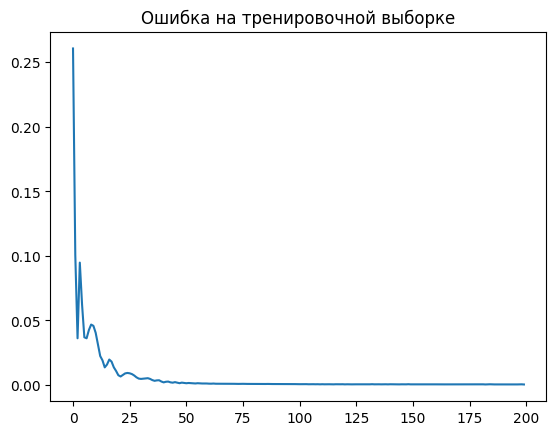

In [242]:
plt.plot(range(n_epoches), train_losses)
plt.title("Ошибка на тренировочной выборке");

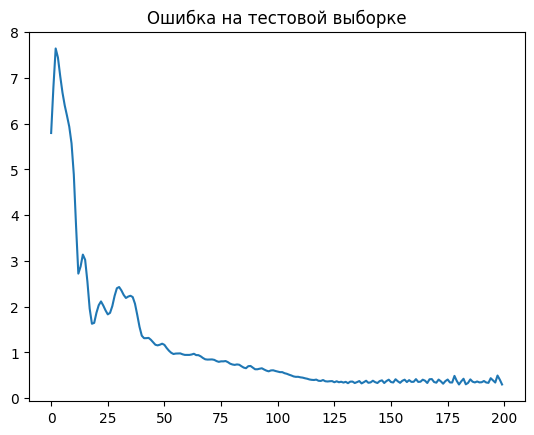

In [243]:
plt.plot(range(n_epoches), test_losses)
plt.title("Ошибка на тестовой выборке");

In [244]:
with torch.no_grad():
    y_pred = model(x_test).cpu()

print('MAE:', mean_absolute_error(y_test.cpu(), y_pred))
print('MSE:', mean_squared_error(y_test.cpu(), y_pred))

MAE: 0.41463847205042836
MSE: 0.29778675856067177


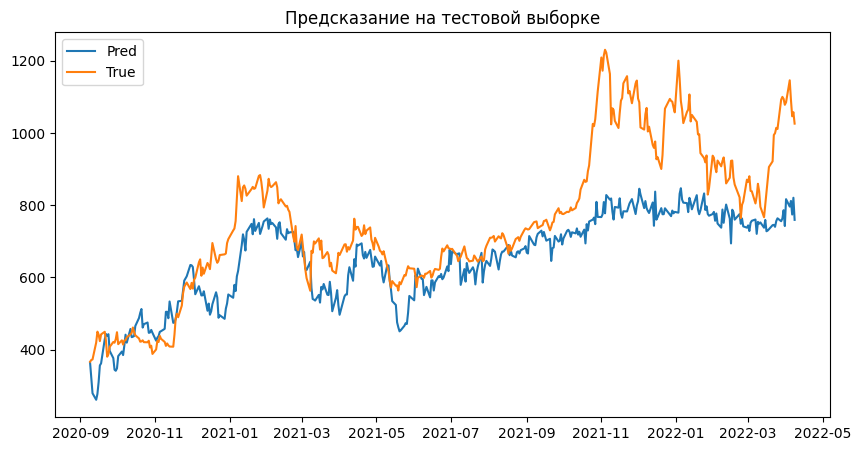

In [245]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][-400:], y_scaler.inverse_transform(y_pred), label='Pred')
plt.plot(df['Date'][-400:], y_scaler.inverse_transform(y_test.cpu()), label='True')
plt.title("Предсказание на тестовой выборке")
plt.legend();

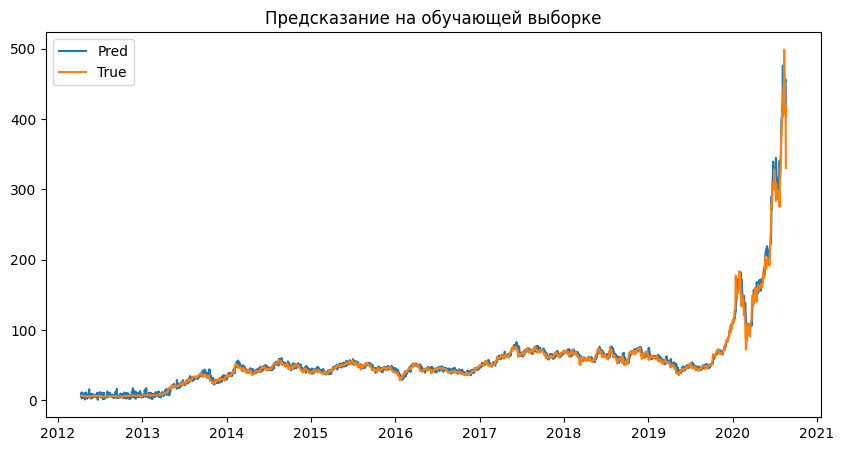

In [246]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][:-400-seq_length], y_scaler.inverse_transform(model(x_train).detach().cpu()), label='Pred')
plt.plot(df['Date'][:-400-seq_length], y_scaler.inverse_transform(y_train.cpu()), label='True')
plt.title("Предсказание на обучающей выборке")
plt.legend();

## Двунаправленная RNN

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.1):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True 
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size) 

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :]) 
        return out


In [204]:
device = torch.device('cuda')
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

model = BiRNN(input_size=4, hidden_size=96, num_layers=4).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

train_losses = []
test_losses = []
n_epoches = 200
for epoch in range(n_epoches):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    test_losses.append(criterion(model(x_test), y_test).item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train loss: {train_losses[-1]:.6f}, Test loss: {test_losses[-1]:.6f}')

Epoch 10, Train loss: 0.032993, Test loss: 5.951816
Epoch 20, Train loss: 0.010160, Test loss: 1.851386
Epoch 30, Train loss: 0.004358, Test loss: 2.113574
Epoch 40, Train loss: 0.002964, Test loss: 2.449444
Epoch 50, Train loss: 0.001530, Test loss: 1.863736
Epoch 60, Train loss: 0.000879, Test loss: 1.274828
Epoch 70, Train loss: 0.000775, Test loss: 1.040309
Epoch 80, Train loss: 0.000694, Test loss: 1.102189
Epoch 90, Train loss: 0.000687, Test loss: 1.070576
Epoch 100, Train loss: 0.000656, Test loss: 1.094427
Epoch 110, Train loss: 0.000596, Test loss: 1.004876
Epoch 120, Train loss: 0.000544, Test loss: 0.990509
Epoch 130, Train loss: 0.000584, Test loss: 0.932405
Epoch 140, Train loss: 0.000523, Test loss: 0.919767
Epoch 150, Train loss: 0.000527, Test loss: 0.870595
Epoch 160, Train loss: 0.000506, Test loss: 0.839710
Epoch 170, Train loss: 0.000475, Test loss: 0.785554
Epoch 180, Train loss: 0.000496, Test loss: 0.821187
Epoch 190, Train loss: 0.000490, Test loss: 0.815621
Ep

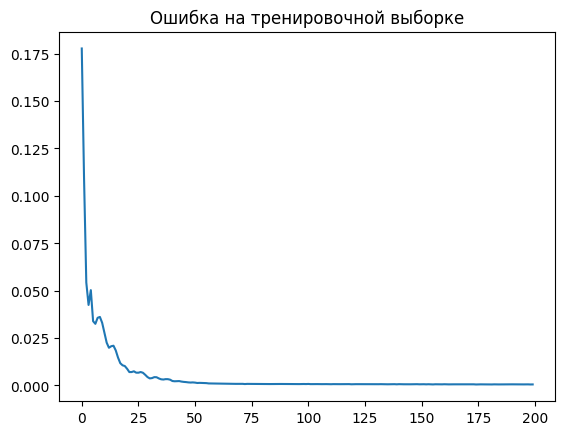

In [206]:
plt.plot(range(n_epoches), train_losses)
plt.title("Ошибка на тренировочной выборке");

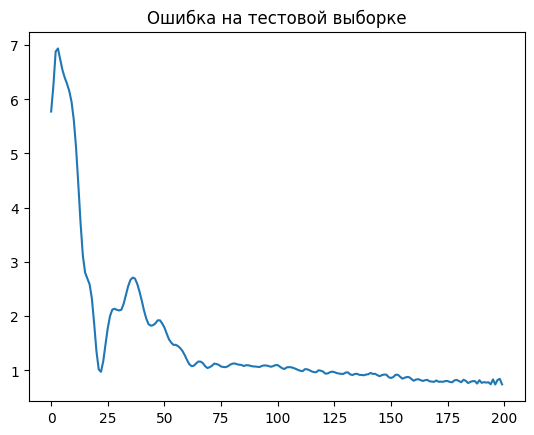

In [207]:
plt.plot(range(n_epoches), test_losses)
plt.title("Ошибка на тестовой выборке");

In [224]:
with torch.no_grad():
    y_pred = model(x_test).cpu()

print('MAE:', mean_absolute_error(y_test.cpu(), y_pred))
print('MSE:', mean_squared_error(y_test.cpu(), y_pred))

MAE: 0.7034690417349339
MSE: 0.7449228258091634


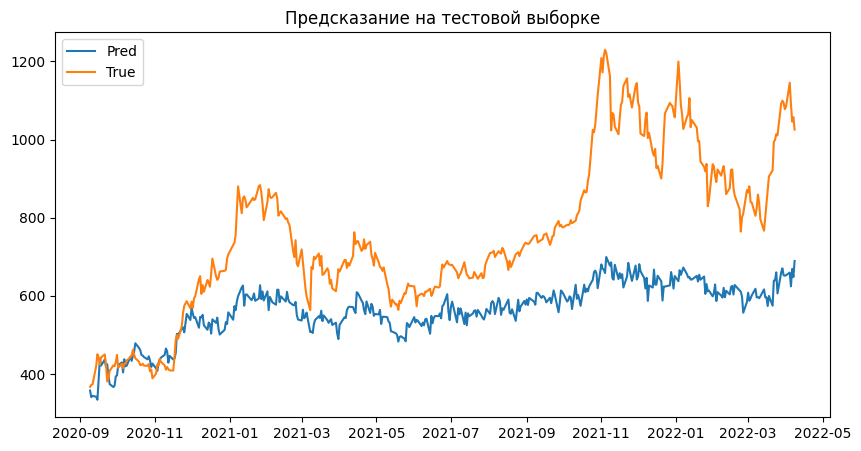

In [225]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][-400:], y_scaler.inverse_transform(y_pred), label='Pred')
plt.plot(df['Date'][-400:], y_scaler.inverse_transform(y_test.cpu()), label='True')
plt.title("Предсказание на тестовой выборке")
plt.legend();

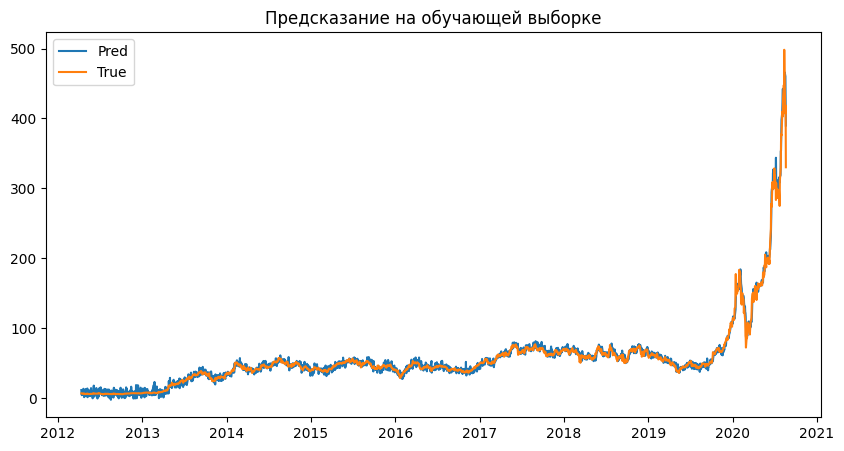

In [220]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][:-400-seq_length], y_scaler.inverse_transform(model(x_train).detach().cpu()), label='Pred')
plt.plot(df['Date'][:-400-seq_length], y_scaler.inverse_transform(y_train.cpu()), label='True')
plt.title("Предсказание на обучающей выборке")
plt.legend();

## Вывод

Глубокая реккурентная сеть во метрикам лучше справляется с задачей, значения часто в нужном диапазоне.

Двунаправленная по метрикам в целом немного хуже (из-за одного неправильно продсказанного момента, примерно в начале 2021 года, весь графики сместился вниз), но лучше предсказал форму изменения, следовательно, её предсказания можно интерпретировать скорее как изменение величины, а не её значение. 

Обе модели в дальних предсказаниях сильно ошибаются по значениям (вероятно, из-за недостатка данных/контекста), но сам по себе рост предсказывают.